# Tutorial 8b: Hierarchical models

(c) 2018 Justin Bois. With the exception of pasted graphics, where the source is noted, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

This document was prepared at [Caltech](http://www.caltech.edu) with financial support from the [Donna and Benjamin M. Rosen Bioengineering Center](http://rosen.caltech.edu).

<img src="caltech_rosen.png">

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t8b_hierarchical.ipynb).*

In [1]:
import io

import numpy as np
import pandas as pd

import bebi103

import altair as alt

import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()

Loading BokehJS ...

In [lecture 7](../lecture_notes/l07_hierarchical_models.pdf) and [its accompanying notebook](../lecture_notes/l07_hierarchical_models.html), we learned about how to construct hierarchical models and how to sample from the resulting posterior distribution. In this tutorial, we will dig a bit deeper and address some of the challenges in sampling out of hierarchical models. I encourage you to make sure you are up to speed on the material from that lecture and the notebook where we used Stan to sample out of the hierarchical model.

This tutorial is born out of discussions I had with Griffin Chure.

## Hierarchical model structure

To think about the stucture of hierarchical models, we will consider the following experimental design, which closely resembles what Griffin was doing in his lab. We are measuring fluorescent intensity of a reporter of gene expression in *E. coli* cells. One Monday, we prepare four batches of *E. coli* and grow them up on plates. From each plate, we seect colonies. We then mount a slide with a selection from a given colony and use fluorescence microscopy to determine the fluorscence level of individual cells. We do a similar experiment on Wednesday, and then another on Thursday.

We model the fluorescence as Gaussian distributed about some mean with a standard deviation.

There is a hierarchical structure here, depicted below.

<img src="hierarchical_model.png">

- Level 0: This level has the hyperparameters $\theta$ and $\sigma$, the mean and standard deviation of fluorescence intensity typical of an *E. coli* cell expressing the fluorescent gene of interest. These are the parameters we ultimately wish to get estimates for.
- Level 1 corresponds to the day the experiment was performed. There will be variability from day to day, and the mean and standard deviation for a given day are conditioned on the hyperparameters, but can vary from the parameters of other days.
- Level 2 corresponds to which batch of cells were used on a given day.
- Level 3 corresponds to the colony of cells chosed from the batch.

The colony-level information then informs the data. In the above diagram, I have indicated how many individual cells are measured in each microscope experiment.

The structure here shows the conditioning. The measured data are parametrized by the colony-level information, which is itself parametrized by the batch-level information, which is itself parametrized by the day-level information, which is finally parametrized by the hyperparameters at the base of the hierarchy.

To keep track of all the hyperparameters, it is easiest to define arrays for the hyperparameters at each level. In this example, we have

\begin{align}
&\text{Level 0 parameter: }\phantom{\text{s}} \theta \\[1em]
&\text{Level 1 parameters: } \theta_1 \equiv (\theta_1^1, \theta_1^2, \theta_1^3) \\[1em]
&\text{Level 2 parameters: } \theta_2 \equiv (\theta_2^1, \theta_2^2, \theta_2^3, \ldots \theta_2^8) \\[1em]
&\text{Level 3 parameters: } \theta_3 \equiv (\theta_3^1, \theta_3^2, \theta_3^3, \ldots \theta_3^{17}).
\end{align}

To complete the formalization of the specification, we need arrays that tell us which hyperparameter in the level above each parameter is conditioned on. Level 1 is special because it is conditioned only by $\theta$. For example, the respective elements in the level 2 parameters are conditioned by the following level 1 conditioners.

\begin{align}
&\text{level 1 hyperparameter conditioners: } (\theta_1^1, \theta_1^1, \theta_1^1, \theta_1^1, \theta_1^2, \theta_1^2, \theta_1^2, \theta_1^3).
\end{align}

To avoid all of the subscripting and superscripting, we can write this as

\begin{align}
\text{index 1: } (1, 1, 1, 1, 2, 2, 2, 3),
\end{align}

with level 3's conditioners in level 2 being

\begin{align}
\text{index 2: } (1, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 8, 8),
\end{align}

and finally the data conditioned by level 3's parameters,

\begin{align}
\text{index 3: } (&1,  1,  1,  1,  1,  2,  2,  3,  4,  4,  5,  5,  6,  6,  7,  7,  7,\\
         &8,  8,  8,  8,  9,  9, 10, 11, 11, 11, 11,
         11, 11, 11, 12, 12, 12,\\
         &13, 13, 13, 13, 13, 13, 14, 15, 15, 15, 16,
        16, 17).
\end{align}


We define that there are $J_1$ parameters in level 1, $J_2$ in level 2, and generically $J_k$ in level $k$. In this case,

\begin{align}
&J_1 = 3,\\[1em]
&J_2 = 8,\\[1em]
&J_3 = 17.\\[1em]
\end{align}

To have a concrete model in mind, we will assume that all colonies have the same variance in intensities, but differing means. We assume further that all hyperparameters are dependent on those at a level above by a Gaussian relationship, and we assume the same variance $\tau$ for relationships all the way down the hierarchy. That is $\tau$ applies for conditioning level 3 on level 2, level 2 on level 1, and level 1 on level 0. We consider a prior on $\theta$ to be a Normal distribution centered on 10 arbitrary fluorescence units with a standard deviation of 3, and $\sigma$ to have a Half-Normal prior. Our statistical model is then defined as follows, with a weakly informative prior on $\tau$.

\begin{align}
&\theta \sim \text{Norm}(10, 3) \\[1em]
&\sigma \sim \text{HalfNorm}(5) \\[1em]
&\tau \sim \text{HalfNorm}(5) \\[1em]
&\theta_1 \sim \text{Norm}(\theta, \tau) \\[1em]
&\theta_2 \sim \text{Norm}(\theta_1, \tau) \\[1em]
&\theta_3 \sim \text{Norm}(\theta_2, \tau) \\[1em]
&y \sim \text{Norm}(\theta_3, \sigma).
\end{align}

Here, we have defined the measurements as $y$, and we have implied that the appropriate conditioning on which specific hyperparameters (as given by index 1, index 2, and index 3 defined above) is considered.

## Coding up the hierarchical model in Stan

Provided we can define arrays for index 1, index 2, and index 3, coding the model up in Stan is surprisingly straightforward. To start, we will use a centered parametrization for clarity. (We will see the problems this causes with sampling momentarily.)

In [2]:
model_code_centered = """
data {
  // Total number of data points
  int N;
  
  // Number of entries in each level of the hierarchy
  int J_1;
  int J_2;
  int J_3;
  
  //Index arrays to keep track of hierarchical structure
  int index_1[J_2];
  int index_2[J_3];
  int index_3[N];
  
  // The measurements
  real y[N];
}


parameters {
  // Hyperparameters level 0
  real theta;
  real<lower=0> sigma;

  // How hyperparameters vary
  real<lower=0> tau;

  // Hyperparameters level 1
  vector[J_1] theta_1;

  // Hyper parameters level 2
  vector[J_2] theta_2;

  // Hyper parameters level 3
  vector[J_3] theta_3;
}


model {
  theta ~ normal(10, 3);
  sigma ~ normal(0, 5);
  tau ~ normal(0, 5);

  theta_1 ~ normal(theta, tau);

  theta_2 ~ normal(theta_1[index_1], tau);
  
  theta_3 ~ normal(theta_2[index_2], tau);

  y ~ normal(theta_3[index_3], sigma);
}
"""

Be sure to carefully read the Stan code. Importantly, note that `theta_1`,`theta_2`, and `theta_3` (and also the corresponding `sigma`'s) are vector valued. Note also that we use indexing to specify which parameters correspond to which day, batch, and colony. In studying the code and the model above, you should be able to see how the hierarchical model is built in Stan.

### A quick aside: generating a data set

I will now generate a tidy data frame containing a data set to analyze with this hierarchical model. These are fabricated data, hence the weird loading with a string (for compactness so we don't have a big code cell).

In [3]:
data_str = ''.join(['day,batch,colony,y\nm,1,1,11.40\nm,1,1,10.54\n',
                    'm,1,1,12.17\nm,1,1,12.41\nm,1,1,9.97\nm,1,2,10.76\n',
                    'm,1,2,9.16\nm,1,3,9.50\nm,2,1,9.34\nm,2,1,10.14\n',
                    'm,2,2,10.72\nm,2,2,10.63\nm,3,1,11.37\nm,3,1,10.51\n',
                    'm,4,1,11.06\nm,4,1,10.68\nm,4,1,12.58\nm,4,2,11.21\n',
                    'm,4,2,11.07\nm,4,2,10.74\nm,4,2,11.68\nm,4,3,10.65\n',
                    'm,4,3,9.06\nw,1,1,10.40\nw,1,2,10.75\nw,1,2,11.42\n',
                    'w,1,2,10.42\nw,1,2,9.18\nw,1,2,10.69\nw,1,2,9.37\n',
                    'w,1,2,11.32\nw,2,1,9.90\nw,2,1,10.53\nw,2,1,10.76\n',
                    'w,3,1,11.08\nw,3,1,9.27\nw,3,1,12.01\nw,3,1,12.20\n',
                    'w,3,1,11.23\nw,3,1,10.96\nr,1,1,9.73\nr,1,2,11.25\n',
                    'r,1,2,9.99\nr,1,2,10.12\nr,1,3,9.65\nr,1,3,10.18\nr,1,4,12.70\n'])

data_str = data_str.replace('m', 'monday').replace('w', 'wednesday').replace('r', 'thursday')
df = pd.read_csv(io.StringIO(data_str))

# Take a look
df.head()

day  batch  colony      y
0  monday      1       1  11.40
1  monday      1       1  10.54
2  monday      1       1  12.17
3  monday      1       1  12.41
4  monday      1       1   9.97

The data are tidy with each row corresponding to a measurement with the appropriate metadata present to determine which day, batch, and colony the measurement was from. Let's take a quick graphical look at the data set.

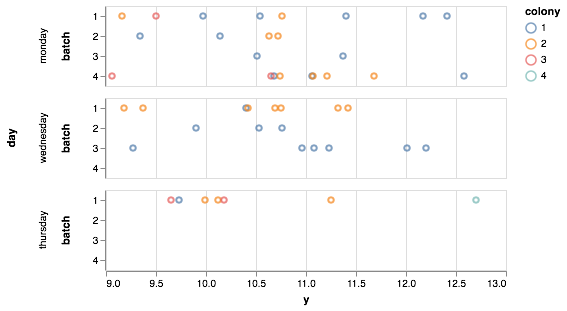

In [4]:
alt.Chart(df,
        height=80
    ).mark_point(
    ).encode(
        x=alt.X('y:Q', scale=alt.Scale(zero=False)),
        y=alt.Y('batch:N'), 
        row=alt.Row('day:N', sort=['monday', 'wednesday', 'thursday']),
        color='colony:N')

### Generating input data for Stan

We should now convert the data frame into a data dictionary that Stan likes, adhering to our more general hierarchical model specification above, i.e., replacing `'day'` with `'index_1'`, `'batch'` with `'index_2'` and `'colony'` with `'index_3'`. Importantly, we should update the original data frame to include these indices (which will be included in Stan's output) that match the respective categorical parameters in the original data set. The function `bebi103.stan.df_to_datadict_hier()` does this. You need to specify the data frame you want to convery, the columns of the data frame corresponding to the levels of the hierarchy *in order*, and the column(s) that have the measured data.

In [5]:
data, df = bebi103.stan.df_to_datadict_hier(df, 
                                            level_cols=['day', 'batch', 'colony'], 
                                            data_cols='y')

# Take a look at the data dictionary
data

{'N': 47,
 'J_1': 3,
 'J_2': 8,
 'J_3': 17,
 'index_1': array([1, 1, 1, 1, 2, 3, 3, 3]),
 'index_2': array([1, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6, 7, 8]),
 'index_3': array([ 1,  1,  1,  1,  1,  2,  2,  3,  4,  4,  5,  5,  6,  6,  7,  7,  7,
         8,  8,  8,  8,  9,  9, 10, 11, 11, 11, 12, 12, 13, 14, 15, 15, 15,
        15, 15, 15, 15, 16, 16, 16, 17, 17, 17, 17, 17, 17]),
 'y': array([11.4 , 10.54, 12.17, 12.41,  9.97, 10.76,  9.16,  9.5 ,  9.34,
        10.14, 10.72, 10.63, 11.37, 10.51, 11.06, 10.68, 12.58, 11.21,
        11.07, 10.74, 11.68, 10.65,  9.06,  9.73, 11.25,  9.99, 10.12,
         9.65, 10.18, 12.7 , 10.4 , 10.75, 11.42, 10.42,  9.18, 10.69,
         9.37, 11.32,  9.9 , 10.53, 10.76, 11.08,  9.27, 12.01, 12.2 ,
        11.23, 10.96])}

It is also instructive to look at the entire updated data frame so you can understand how the labeling of indices works.

In [6]:
df

day  batch  colony      y  day_stan  batch_stan  colony_stan
0      monday      1       1  11.40         1           1            1
1      monday      1       1  10.54         1           1            1
2      monday      1       1  12.17         1           1            1
3      monday      1       1  12.41         1           1            1
4      monday      1       1   9.97         1           1            1
5      monday      1       2  10.76         1           1            2
6      monday      1       2   9.16         1           1            2
7      monday      1       3   9.50         1           1            3
8      monday      2       1   9.34         1           2            4
9      monday      2       1  10.14         1           2            4
10     monday      2       2  10.72         1           2            5
11     monday      2       2  10.63         1           2            5
12     monday      3       1  11.37         1           3            6
13     monday      3       1  10.51         1           3            6
14     monday      4       1  11.06         1           4            7
15     monday      4       1  10.68         1           4            7
16     monday      4       1  12.58         1           4            7
17     monday      4       2  11.21         1           4            8
18     monday      4       2  11.07         1           4            8
19     monday      4       2  10.74         1           4            8
20     monday      4       2  11.68         1           4            8
21     monday      4       3  10.65         1           4            9
22     monday      4       3   9.06         1           4            9
40   thursday      1       1   9.73         2           5           10
41   thursday      1       2  11.25         2           5           11
42   thursday      1       2   9.99         2           5           11
43   thursday      1       2  10.12         2           5           11
44   thursday      1       3   9.65         2           5           12
45   thursday      1       3  10.18         2           5           12
46   thursday      1       4  12.70         2           5           13
23  wednesday      1       1  10.40         3           6           14
24  wednesday      1       2  10.75         3           6           15
25  wednesday      1       2  11.42         3           6           15
26  wednesday      1       2  10.42         3           6           15
27  wednesday      1       2   9.18         3           6           15
28  wednesday      1       2  10.69         3           6           15
29  wednesday      1       2   9.37         3           6           15
30  wednesday      1       2  11.32         3           6           15
31  wednesday      2       1   9.90         3           7           16
32  wednesday      2       1  10.53         3           7           16
33  wednesday      2       1  10.76         3           7           16
34  wednesday      3       1  11.08         3           8           17
35  wednesday      3       1   9.27         3           8           17
36  wednesday      3       1  12.01         3           8           17
37  wednesday      3       1  12.20         3           8           17
38  wednesday      3       1  11.23         3           8           17
39  wednesday      3       1  10.96         3           8           17

We now have the necessary data for Stan's sampler.

### Drawing samples and checking diagnostics

So, let's sample and see what we get!

In [7]:
sm_centered = bebi103.stan.StanModel(model_code=model_code_centered)

samples_centered = sm_centered.sampling(data=data, seed=2389412)

# Convert to data frame for easy use later
df_mcmc_centered = bebi103.stan.to_dataframe(samples_centered)

Using cached StanModel.


/Users/Justin/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


That was fast! Hopefully everything worked ok for this model. Let's start by checking all of the dianostics to see if there were any issues.

In [8]:
bebi103.stan.check_all_diagnostics(samples_centered)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
16.0 of 4000 (0.4%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
Chain 1: E-BFMI = 0.14425397626075254
Chain 2: E-BFMI = 0.09644388929691175
Chain 3: E-BFMI = 0.07174832333063334
Chain 4: E-BFMI = 0.11481824586039996
  E-BFMI below 0.2 indicates you may need to reparametrize your model.


20

The E-BFMI is a little bit low, which suggests there may be an issue with sampling. Furthermore, there are a few divergences. Not many, and they could be false positives, but we should check to see if there is a pattern to the divergences. To start looking for the pattern, let's make a parallel coordinate plot. We need to be careful with transformations of the parameters to get them all on the same scale so we can look at the plot. We will divide all $\theta$ samples by 10, and then scale `lp__` by its maximal value.

In [9]:
# Which parametets to use in parallel coordinate plot
pars = (['theta', 'sigma', 'tau'] +
        list(df_mcmc_centered.columns[df_mcmc_centered.columns.str.contains('theta_')]) +
        ['lp__'])

# Transformations to get them all on the same scale
transformation = (  [lambda x: x / 10, None, None] 
                  + [lambda x: x / 10]*(len(pars)-4)
                  + [lambda x: x / np.abs(x).max()])

bokeh.io.show(bebi103.viz.parcoord_plot(samples_centered,
                                        pars=pars,
                                        transformation=transformation,
                                        xtick_label_orientation='vertical'))

Even though there are very few divergences, they all go through low $\tau$, and have realtively high log probability. This is a symptom of hitting a funnel. We can see this in the corner plot.

In [10]:
bokeh.io.show(bebi103.viz.corner(samples_centered, pars=['theta', 'sigma', 'tau']))

Looking at the `tau` versus `theta` plot, we see that the divergences are for small `tau`. Zooming in on the bottom of that plot shows that the sampler is hitting the entry to a funnel; it cannot sample down to `tau` values close to zero. As we saw in the [previous tutorial](t8a_mcmc_diagnostics.html), we can possibly alleviate this problem by uncentering the model.

## A non-centered parametrization

To uncenter the model, we reparametrize our model as follows.

\begin{align}
&\theta \sim \text{Norm}(10, 3) \\[1em]
&\sigma \sim \text{HalfNorm}(5) \\[1em]
&\tau \sim \text{HalfNorm}(5) \\[1em]
&\tilde{\theta}_1 \sim \text{Norm}(0, 1) \\[1em]
&\theta_1 = \theta + \tau \tilde{\theta}_1 \\[1em]
&\tilde{\theta}_2 \sim \text{Norm}(0, 1) \\[1em]
&\theta_2 = \theta_1 + \tau \tilde{\theta}_2 \\[1em]
&\tilde{\theta}_3 \sim \text{Norm}(0, 1) \\[1em]
&\theta_3 = \theta_2 + \tau \tilde{\theta}_3 \\[1em]
&y \sim \text{Norm}(\theta_3, \sigma).
\end{align}

This frees the sampler to explore standard Normal distributions and then uses a change of variables to sample the funnel.

Let's code this up in Stan.

In [11]:
model_code_noncentered = """
data {
  // Total number of data points
  int N;
  
  // Number of entries in each level of the hierarchy
  int J_1;
  int J_2;
  int J_3;
  
  //Index arrays to keep track of hierarchical structure
  int index_1[J_2];
  int index_2[J_3];
  int index_3[N];
  
  // The measurements
  real y[N];
}


parameters {
  // Hyperparameters level 0
  real theta;
  real<lower=0> sigma;

  // How hyperparameters vary
  real<lower=0> tau;

  // Hyperparameters level 1
  vector[J_1] theta_1_tilde;

  // Hyper parameters level 2
  vector[J_2] theta_2_tilde;

  // Hyper parameters level 3
  vector[J_3] theta_3_tilde;
}


transformed parameters {
  // Transformations for noncentered
  vector[J_1] theta_1 = theta + tau * theta_1_tilde;
  vector[J_2] theta_2 = theta_1[index_1] + tau * theta_2_tilde;
  vector[J_3] theta_3 = theta_2[index_2] + tau * theta_3_tilde;
}


model {
  theta ~ normal(10, 3);
  sigma ~ normal(0, 5);
  tau ~ normal(0, 5);

  theta_1_tilde ~ normal(0, 1);
  theta_2_tilde ~ normal(0, 1);
  theta_3_tilde ~ normal(0, 1);

  y ~ normal(theta_3[index_3], sigma);
}
"""

Let's draw our samples and see if we were able to alleviate the problems we diagnosed with the centered parametrizations.

In [12]:
sm_noncentered = bebi103.stan.StanModel(model_code=model_code_noncentered)

samples_noncentered = sm_noncentered.sampling(data=data, seed=202174)

# Convert to data frame for easy use later
df_mcmc_noncentered = bebi103.stan.to_dataframe(samples_noncentered)

Using cached StanModel.


Let's first check the diagnostics.

In [13]:
bebi103.stan.check_all_diagnostics(samples_noncentered)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
5.0 of 4000 (0.125%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


4

The E-BFMI problems are gone, but we sill have a few (fewer than in the centered version) divergences. Let's look for causes of the divergences with a parallel coordinate plot.

In [14]:
bokeh.io.show(bebi103.viz.parcoord_plot(samples_noncentered,
                                        pars=pars,
                                        transformation=transformation,
                                        xtick_label_orientation='vertical'))

It is hard to see an immediate pattern here. Let's look at the corner plot to see if anything is obvious.

In [15]:
bokeh.io.show(bebi103.viz.corner(samples_noncentered, pars=['theta', 'sigma', 'tau']))

There does not seem to be any apparent pattern in the divergences, which means that they could be false positives, so we will accept these samples. At any rate, we can deal with them by increasing the `adapt_delta` parameter of the sampler (which I won't do here, but you can try by yourself; it works). Importantly, zooming in on the `tau` versus `theta` plot shows that the sampler is now effectively sampling small values of $\tau$, effectively sampling down toward zero. We can see this more clearly by comparing the samples from the centered versus noncentered parametrizations with $\tau$ on a logarithmic scale.

In [16]:
p = bokeh.plotting.figure(height=400, width=450, 
                          x_axis_label='θ', y_axis_label='τ', 
                          y_axis_type='log')
p.circle(df_mcmc_centered['theta'], df_mcmc_centered['tau'], 
         legend='centered', alpha=0.2)
p.circle(df_mcmc_noncentered['theta'], df_mcmc_noncentered['tau'], 
         legend='noncentered', color='orange', alpha=0.2)
p.legend.location = 'bottom_right'
p.legend.click_policy = 'hide'

bokeh.io.show(p)

We have much better sampling for low $\tau$. Let's think for a moment about why this is important. A large value of $\tau$ means that the parameters governing the outcomes of the respective experiments are essentially independent. A small value of $\tau$ means that the parameters governing the experiments are all nearly the same. This corresponds to pooling all of the results together in a single data set. So, you can think of $\tau$ like a slider; small $\tau$ gives the extreme model where the experiments are all pooled together, and large $\tau$ gives the opposite extreme, where the experiments are all independent. The whole point of using a hierarchical model is to capture all of the possible behavior between (and including) these two extremes. If we cannot effectively sample $\tau$, we are not capturing the possible structure of the data set.

## Conclusions

Hierarchical modeling presents special challenges for samplers. There are tricks we can do to improve the performance of HMC samplers in exploring the parameter space, such as using non-centered parametrizations and encouraging the sampler to take smaller steps by tuning the `adapt_delta` parameter. Importantly, though, you should carefully check the diagnostics of your sampler. This is true even if you are not working with a hierarchical model.

In [17]:
%load_ext watermark

In [18]:
%watermark -v -p numpy,pandas,pystan,bokeh,altair,bebi103,jupyterlab

CPython 3.7.0
IPython 7.1.1

numpy 1.15.4
pandas 0.23.4
pystan 2.17.1.0
bokeh 1.0.1
altair 2.2.2
bebi103 0.0.35
jupyterlab 0.35.3
